In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import nltk
nltk.download('punkt') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

^C


Fri Jun 14 11:53:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.24                 Driver Version: 546.24       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P4              14W /  55W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
print(os.listdir("../data"))

['test.ft.txt.bz2', 'train.ft.txt.bz2']


# Load data

In [4]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('../data/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('../data/test.ft.txt.bz2')

NameError: name 'bz2' is not defined

In [6]:
train_labels, train_texts = train_labels[:10000], train_texts[:10000]
test_labels, test_texts = test_labels[:2000], test_texts[:2000]

# Data preprocessing

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_texts, train_labels, test_size=0.2, stratify=train_labels)

print("Train data:",  len(X_train), len(y_train))
print("Valid data:",  len(X_val), len(y_val))

NameError: name 'train_texts' is not defined

In [8]:
# tf.strings.lower('ONE HOT ENCODING').numpy()
nltk.word_tokenize('ONE HOT ENCODING')

['ONE', 'HOT', 'ENCODING']

In [9]:
stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

In [1]:
def data_preprocessing(review):

  # data cleaning
  review = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  review =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words
  review = re.sub(r"http\S+", "",review) #Removing URLs 
  
  # lowercase
  review = review.lower()
  
  # tokenization
  tokens = nltk.word_tokenize(review) # converts review to tokens
  
  # stop_words removal
  review = [word for word in tokens if word not in stop_words] #removing stop words
  
  # lemmatization
  # review = [lemmatizer.lemmatize(word) for word in review]
  
  # join words in preprocessed review
  review = ' '.join(review)
  
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text) #Removing emojis
  
  return review

In [2]:
prep_train_texts = [data_preprocessing(text) for text in X_train]

NameError: name 'X_train' is not defined

In [12]:
prep_valid_texts = [data_preprocessing(text) for text in X_val]

In [13]:
prep_test_texts = [data_preprocessing(text) for text in test_texts]

In [14]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(prep_train_texts)
tk_train_texts = tokenizer.texts_to_sequences(prep_train_texts)
tk_val_texts = tokenizer.texts_to_sequences(prep_valid_texts)
tk_test_texts = tokenizer.texts_to_sequences(prep_test_texts)

In [15]:
len(tk_test_texts[10])

18

In [16]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
tk_train_texts = pad_sequences(tk_train_texts, maxlen=MAX_LENGTH)
tk_val_texts = pad_sequences(tk_val_texts, maxlen=MAX_LENGTH)
tk_test_texts = pad_sequences(tk_test_texts, maxlen=MAX_LENGTH)

In [17]:
tk_test_texts.shape

(2000, 1015)

# Model Training

In [18]:
from keras.layers import BatchNormalization


def build_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

def build_rnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.LSTM(128, return_sequences=True)(embedded)
    x = layers.LSTM(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

model = build_model()
rnn_model = build_rnn_model()

In [47]:
with tf.device('/gpu:0'):
    model.fit(
        tk_train_texts, 
        y_train,
        batch_size=128,
        epochs=2,
        validation_data=(tk_val_texts, y_val), )

Epoch 1/2
22500/22500 [==============================] - 803s 36ms/step - loss: 0.2742 - binary_accuracy: 0.8821 - val_loss: 0.2612 - val_binary_accuracy: 0.8905
Epoch 2/2
22500/22500 [==============================] - 642s 29ms/step - loss: 0.2555 - binary_accuracy: 0.8915 - val_loss: 0.2643 - val_binary_accuracy: 0.8895


In [19]:
with tf.device('/gpu:0'):
    rnn_model.fit(
        tk_train_texts, 
        y_train,
        batch_size=128,
        epochs=2,
        validation_data=(tk_val_texts, y_val), )

Epoch 1/2
63/63 [==============================] - 16s 165ms/step - loss: 0.5569 - binary_accuracy: 0.7160 - val_loss: 0.4539 - val_binary_accuracy: 0.7835
Epoch 2/2
63/63 [==============================] - 11s 176ms/step - loss: 0.2883 - binary_accuracy: 0.8857 - val_loss: 0.3330 - val_binary_accuracy: 0.8685


In [20]:
# preds = model.predict(tk_test_texts)
preds = rnn_model.predict(tk_test_texts)

63/63 [==============================] - 4s 60ms/step


In [24]:
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.843
F1 score: 0.8534
ROC AUC score: 0.9175


In [22]:
print(preds.shape)
preds

(2000, 1)


array([[0.95963204],
       [0.9952371 ],
       [0.6793907 ],
       ...,
       [0.9908584 ],
       [0.98158306],
       [0.87312865]], dtype=float32)

In [25]:
txt1 = test_texts[100]
print(txt1)
prueba = data_preprocessing(txt1)
print(prueba)
prueba_tk = tokenizer.texts_to_sequences([prueba])
print(prueba_tk)
tk_prueba_txt = pad_sequences(prueba_tk, maxlen=1015)
print(tk_prueba_txt)
# model.predict(tk_prueba_txt)
rnn_model.predict(tk_prueba_txt)

same problems as munchkin version: Ditto to other complaints - won't separate easily- either by unscrewing or prizing. Cheap, flimsy, leaks water also because no gasket. I'm looking for something else and hoping reviewers will give honest good advice . . . this almost identical to product by Munchkin
problem munchkin version ditto complaint separate easily either unscrewing prizing cheap flimsy leak water also gasket looking something else hoping reviewer give honest good advice almost identical product munchkin
[[90, 11154, 77, 10369, 956, 2410, 404, 312, 328, 1165, 1141, 594, 32, 6651, 116, 83, 244, 663, 461, 63, 1176, 7, 905, 196, 3548, 26, 11154]]
[[    0     0     0 ...  3548    26 11154]]
1/1 [==============================] - 0s 102ms/step


array([[0.24719687]], dtype=float32)

1/1 [==============================] - 0s 195ms/step


array([[0.66053355]], dtype=float32)

In [140]:
model.save("../models", include_optimizer=False)

INFO:tensorflow:Assets written to: ../models\assets


INFO:tensorflow:Assets written to: ../models\assets


# Data preprocessing details

In [27]:
list_proc = test_texts.copy()
list_proc = list_proc[:100]
list_proc

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of s

In [28]:
# Lower case
[text.lower() for text in list_proc]

['great cd: my lovely pat has one of the great voices of her generation. i have listened to this cd for years and i still love it. when i\'m in a good mood it makes me feel better. a bad mood just evaporates like sugar in the rain. this cd just oozes life. vocals are jusat stuunning and lyrics just kill. one of life\'s hidden gems. this is a desert isle cd in my book. why she never made it big is just beyond me. everytime i play this, no matter black, white, young, old, male, female everybody says one thing "who was that singing ?"',
 "one of the best game music soundtracks - for a game i didn't really play: despite the fact that i have only played a small portion of the game, the music i heard (plus the connection to chrono trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. there is an incredible mix of fun, epic, and emotional songs. those sad and beautiful tracks i especially like, as there's not too many of those kinds of s

In [29]:
# nltk tokenization
nltk.word_tokenize(list_proc[0])

['Great',
 'CD',
 ':',
 'My',
 'lovely',
 'Pat',
 'has',
 'one',
 'of',
 'the',
 'GREAT',
 'voices',
 'of',
 'her',
 'generation',
 '.',
 'I',
 'have',
 'listened',
 'to',
 'this',
 'CD',
 'for',
 'YEARS',
 'and',
 'I',
 'still',
 'LOVE',
 'IT',
 '.',
 'When',
 'I',
 "'m",
 'in',
 'a',
 'good',
 'mood',
 'it',
 'makes',
 'me',
 'feel',
 'better',
 '.',
 'A',
 'bad',
 'mood',
 'just',
 'evaporates',
 'like',
 'sugar',
 'in',
 'the',
 'rain',
 '.',
 'This',
 'CD',
 'just',
 'oozes',
 'LIFE',
 '.',
 'Vocals',
 'are',
 'jusat',
 'STUUNNING',
 'and',
 'lyrics',
 'just',
 'kill',
 '.',
 'One',
 'of',
 'life',
 "'s",
 'hidden',
 'gems',
 '.',
 'This',
 'is',
 'a',
 'desert',
 'isle',
 'CD',
 'in',
 'my',
 'book',
 '.',
 'Why',
 'she',
 'never',
 'made',
 'it',
 'big',
 'is',
 'just',
 'beyond',
 'me',
 '.',
 'Everytime',
 'I',
 'play',
 'this',
 ',',
 'no',
 'matter',
 'black',
 ',',
 'white',
 ',',
 'young',
 ',',
 'old',
 ',',
 'male',
 ',',
 'female',
 'EVERYBODY',
 'says',
 'one',
 'thing

In [30]:
# Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer


# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(list_proc)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([list_proc[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'great': 813, 'cd': 302, 'my': 1245, 'lovely': 1126, 'pat': 1378, 'has': 847, 'one': 1318, 'of': 1308, 'the': 1942, 'voices': 2109, 'her': 867, 'generation': 782, 'have': 850, 'listened': 1093, 'to': 1983, 'this': 1960, 'for': 741, 'years': 2218, 'and': 94, 'still': 1843, 'love': 1124, 'it': 985, 'when': 2160, 'in': 936, 'good': 801, 'mood': 1226, 'makes': 1146, 'me': 1170, 'feel': 695, 'better': 212, 'bad': 158, 'just': 1012, 'evaporates': 641, 'like': 1083, 'sugar': 1877, 'rain': 1525, 'oozes': 1322, 'life': 1081, 'vocals': 2107, 'are': 118, 'jusat': 1011, 'stuunning': 1869, 'lyrics': 1136, 'kill': 1026, 'hidden': 876, 'gems': 779, 'is': 977, 'desert': 497, 'isle': 982, 'book': 228, 'why': 2173, 'she': 1711, 'never': 1266, 'made': 1139, 'big': 214, 'beyond': 213, 'everytime': 649, 'play': 1417, 'no': 1272, 'matter': 1166, 'black': 218, 'white': 2166, 'young': 2223, 'old': 1314, 'male': 1148, 'female': 701, 'everybody': 645, 'says': 1649, 'thing': 1953, 'who': 2167, 'was': 2126, 'tha

In [31]:
# Bag of words with keras
tokenizer_prueb = Tokenizer()
tokenizer_prueb.fit_on_texts(list_proc)
# summarize what was learned
print(tokenizer_prueb.word_counts)
print(tokenizer_prueb.document_count)
print(tokenizer_prueb.word_index)
print(tokenizer_prueb.word_docs)

OrderedDict([('great', 34), ('cd', 10), ('my', 78), ('lovely', 1), ('pat', 1), ('has', 29), ('one', 44), ('of', 194), ('the', 461), ('voices', 1), ('her', 24), ('generation', 1), ('i', 272), ('have', 66), ('listened', 1), ('to', 224), ('this', 156), ('for', 99), ('years', 6), ('and', 240), ('still', 14), ('love', 14), ('it', 189), ('when', 26), ("i'm", 19), ('in', 99), ('a', 210), ('good', 19), ('mood', 3), ('makes', 3), ('me', 39), ('feel', 6), ('better', 16), ('bad', 14), ('just', 33), ('evaporates', 1), ('like', 34), ('sugar', 1), ('rain', 1), ('oozes', 1), ('life', 8), ('vocals', 1), ('are', 39), ('jusat', 1), ('stuunning', 1), ('lyrics', 1), ('kill', 2), ("life's", 1), ('hidden', 1), ('gems', 1), ('is', 132), ('desert', 1), ('isle', 1), ('book', 94), ('why', 9), ('she', 18), ('never', 7), ('made', 11), ('big', 4), ('beyond', 3), ('everytime', 1), ('play', 7), ('no', 28), ('matter', 2), ('black', 6), ('white', 3), ('young', 1), ('old', 7), ('male', 2), ('female', 1), ('everybody', 

In [32]:
# Word2vec
from gensim.models import Word2Vec

# define training data
# sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
# 			['this', 'is', 'the', 'second', 'sentence'],
# 			['yet', 'another', 'sentence'],
# 			['one', 'more', 'sentence'],
# 			['and', 'the', 'final', 'sentence']]
# train model
# word2vec = Word2Vec(sentences, min_count=1)
word2vec = Word2Vec([nltk.word_tokenize(text) for text in list_proc], min_count=1)
# summarize the loaded model
print(word2vec)
# summarize vocabulary
words = list(word2vec.wv.index_to_key)
print(words)
# access vector for one word
print(word2vec.wv['book'])

Word2Vec<vocab=2505, vector_size=100, alpha=0.025>
['.', 'the', ',', 'I', 'and', 'to', 'of', 'a', 'it', 'is', 'this', ':', 'that', 'for', 'book', 'in', 'was', 'you', '!', 'my', 'with', 'have', 'on', "n't", 'but', "'s", 'The', 'not', 'read', 'are', 'This', 'me', 'one', 'all', 'It', 'would', 'as', 'be', 'just', 'do', 'so', 'like', 'about', 'has', 'at', 'if', '(', 'from', ')', 'an', '...', 'who', 'had', 'very', 'great', 'no', 'up', 'i', 'A', "''", 'when', 'product', 'many', 'work', 'will', 'your', 'did', 'can', 'they', 'more', 'some', 'there', 'books', 'get', "'m", 'her', 'by', 'which', 'good', '``', 'he', '?', 'other', 'into', 'she', 'better', 'or', 'time', 'any', 'through', 'does', 'out', 'really', 'author', 'off', 'well', 'how', 'size', 'only', 'we', 'then', 'too', 'after', '-', 'what', 'still', 'been', '&', 'game', 'know', 'because', 'way', 'bad', 'even', 'story', 'much', 'love', 'before', 'his', 'now', 'first', 'works', 'best', 'use', 'reading', 'reader', 'than', 'think', '5', 'If', 

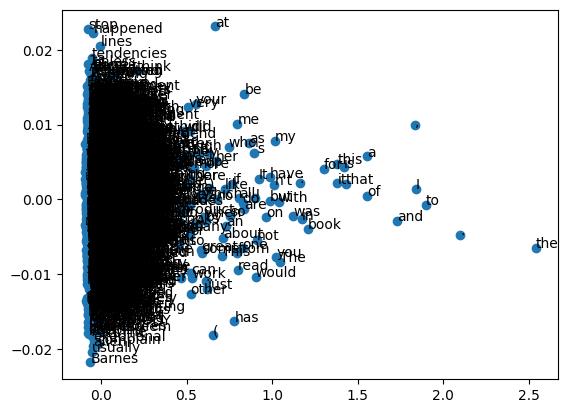

In [33]:
from sklearn.decomposition import PCA
from matplotlib import pyplot


# fit a 2D PCA model to the vectors
X = word2vec.wv[word2vec.wv.index_to_key]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(word2vec.wv.index_to_key)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()